## best deck yesterday

What you want:
- [x] top 10 archetypes yesterday
    - top_archetypes
- [x] the best archetype yesterday w/ winrate
    - number_one
- [x] the popular decks in that archetype w/ winrate
    - best_decks
- [x] the optimal game length for that deck
- [x] how that deck has been growing in the meta
    - [x] in popularity
    - [x] in winrate
    
V2
- [x] playrate graphs as % of overall playrate
- [x] auto-generate text for reddit post

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from datetime import date
from datetime import timedelta
from fpdf import FPDF

from dateutil import parser
import datetime
import dataframe_image as dfi

In [2]:
df = pd.read_csv(r'./../data/raw/lor_ranked_data_all.csv')

In [3]:
this_day = str(date.today())
yesterday = str(date.today() - timedelta(days = 1))
df_date = df[(df['game_start_time_utc'] < this_day) & (df['game_start_time_utc'] > yesterday)] # keep only the games played yesterday
df_date.shape

(59454, 14)

In [4]:
d = datetime.datetime.strptime(yesterday, '%Y-%m-%d')
pdf_yesterday = d.strftime('%b %d, %Y')

In [5]:
#clean data
df_small = df_date[['game_outcome', 'total_turn_count', 'archetype']]
archetypes = df_small['archetype'].value_counts() # find the unique archetypes being played
popular_archetypes = archetypes[archetypes > len(df_small)/50] #only keep popular archetypes ##################################################################################
popular_list = list(popular_archetypes.index) # make a list of popular archetypes
df_small_popular = df_small.loc[df['archetype'].isin(popular_list)] # filter df to only keep popular archetypes
df_small_popular = df_small_popular[df_small_popular['game_outcome'] != "tie"] # drop ties

In [6]:
#DELETE
# WHAT IS THE MINIUMUM SAMPLE SIZE FOR THE ARCHETYPE?
df_small = df_date[['game_outcome', 'total_turn_count', 'archetype']]
archetypes = df_small['archetype'].value_counts()
len(df_small)/50

1189.08

In [7]:
#calculate winrate by archetype
df2 = df_small_popular.groupby(['archetype', 'game_outcome']).size() #get win/loss for major archetypes
df2 = df2.groupby(level=0).transform(lambda x: (x / x.sum()).round(2)*100) #get win/loss % for major archetypes
df2.drop('loss', level=1, axis=0, inplace=True) #drop loss %
df2 = df2.droplevel(level=1) #drop win/loss

In [8]:
#top 10 archetypes
df2.sort_values(ascending=False, inplace=True)
top_archetypes = df2[:10]
top_archetypes

archetype
Miss Fortune Twisted Fate Gangplank (NX)    57.0
Tryndamere Trundle (SI)                     57.0
Elise Vi Jayce                              54.0
Lux Jayce                                   54.0
Yuumi Pantheon (DE)                         54.0
Ezreal Caitlyn (NX)                         53.0
Azir Xerath                                 52.0
Akshan Udyr                                 48.0
Ashe LeBlanc                                48.0
Garen Jarvan IV                             47.0
dtype: float64

In [9]:
n_plays = archetypes[str(top_archetypes.index[0])]

In [10]:
top_archetypes.to_csv('test1.csv')

In [11]:
#best archetype yesterday
number_one = df2.index[0]

In [12]:
x = df_date.loc[df_date['archetype'] == df2.index[0]]
archetypes = x['deck_code'].value_counts() # find the unique archetypes being played
archetypes = archetypes[archetypes > 100] #only keep popular archetypes
popular_list = list(archetypes.index) # make a list of popular archetypes
x = x.loc[df['deck_code'].isin(popular_list)] # filter df to only keep popular archetypes

In [13]:
#if this errors out it is because your [archetypes > x] threshold is too high
df_champ = x.groupby(['deck_code', 'game_outcome']).size() #get win/loss for major archetypes
df_champ = df_champ.groupby(level=0).transform(lambda x: (x / x.sum()).round(3)*100) #get win/loss % for major archetypes
df_champ.drop('loss', level=1, axis=0, inplace=True) #drop loss %
df_champ = df_champ.droplevel(level=1) #drop win/loss

In [14]:
best_decks = df_champ.sort_values(ascending=False)
best_decks = best_decks[:10]
best_decks

deck_code
CICACBIGAEBAEAYDAQBQEBQWEY6AIAIDAIGA6KACAEAQGJIDAIDCALJ6AEBAEBQ2HI    51.6
dtype: float64

## the optimal game length for that archetype

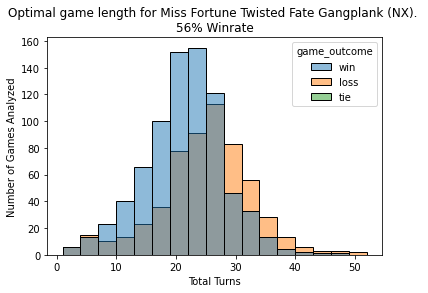

In [15]:
thing = [top_archetypes.index[0]]
df_x = df_small.loc[(df_small['archetype'].isin(thing))]
winrate = int(df2.at[top_archetypes.index[0]])
plt.figure()
sns.histplot(x=df_x['total_turn_count'], hue=df_small['game_outcome'], bins=30, binwidth=3)
plt.title(f'Optimal game length for {top_archetypes.index[0]}. \n{winrate}% Winrate')
plt.xlabel('Total Turns')
plt.ylabel('Number of Games Analyzed')
# plt.legend(title="Outcome", labels=['win', 'loss'], frameon=True)
plt.savefig(f'gameLength-{this_day}-{top_archetypes.index[0]}-{winrate}.png', bbox_inches="tight", dpi=200, transparent=True)

##  how that deck has been growing in the meta
 - in popularity
 - in winrate

In [16]:
# # Number of of games chart
# df_x = df[df['archetype'] == df2.index[0]] # make dataframe of just the best archetype
# thing = pd.to_datetime(df_x['game_start_time_utc'].str[:10]) # just get the dates
# dates = thing.value_counts() # how many games are played per day?
# dates.sort_index(ascending=True, inplace=True) # sort the dates

# fig, ax = plt.subplots() # graph to see if you're missing any dates
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# plt.title(f'{df2.index[0]} playrate over time \n{winrate}% Winrate overall')
# plt.xlabel('Date')
# plt.ylabel('Number of Games')
# dates.plot(ax=ax, kind='line')
# plt.savefig(f'archetypePopularity.png', bbox_inches="tight", dpi=200, transparent=True)

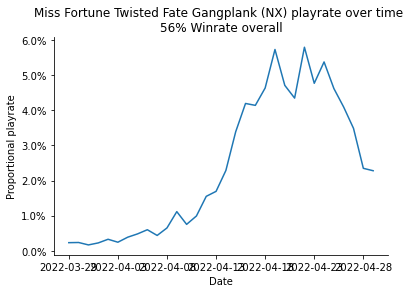

In [17]:
# proportional playrate chart
df_x = df[df['archetype'] == df2.index[0]] # make dataframe of just the best archetype
thing = df_x['game_start_time_utc'].str[:10] # just get the dates
games_arch = thing.value_counts() # how many games are played per day?
games_arch.sort_index(ascending=True, inplace=True) # sort the dates

# the total number of games played on any given day
_ = df['game_start_time_utc'].str[:10]
_ = _.value_counts()
_.sort_index(ascending=True, inplace=True)

# get % playrate
dates = games_arch.divide(_)
dates = round(dates*100, 3)

# plot
fig, ax = plt.subplots() # graph to see if you're missing any dates
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
plt.title(f'{df2.index[0]} playrate over time \n{winrate}% Winrate overall')
plt.xlabel('Date')
plt.ylabel('Proportional playrate')
dates.plot(ax=ax, kind='line')
plt.savefig(f'archetypePopularity.png', bbox_inches="tight", dpi=200, transparent=True)

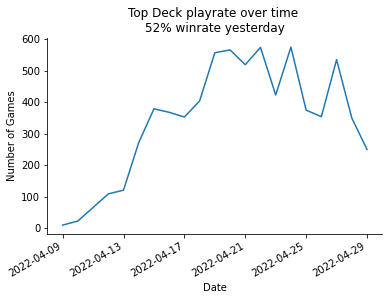

In [18]:
df_x = df[df['deck_code'] == best_decks.index[0]] # make dataframe of just the best deck
thing = pd.to_datetime(df_x['game_start_time_utc'].str[:10]) # just get the dates
dates = thing.value_counts() # how many games are played per day?
dates.sort_index(ascending=True, inplace=True) # sort the dates

fig, ax = plt.subplots() # graph to see if you're missing any dates
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title(f'Top Deck playrate over time \n{round(best_decks[0])}% winrate yesterday')
plt.xlabel('Date')
plt.ylabel('Number of Games')
dates.plot(ax=ax, kind='line')
plt.savefig(f'deckPopularity.png', bbox_inches="tight", dpi=200, transparent=True)

## generate report

In [19]:
# make png for top archetypes
_archetypes = pd.DataFrame(top_archetypes, columns=['winrate']) #convert top_archetypes to dataframe
_archetypes.reset_index(inplace=True) # reset df index
df_styled = _archetypes.style.background_gradient()
dfi.export(df_styled,"top_archetypes_winrate.png")

C:\Users\jagod\anaconda3\lib\site-packages\dataframe_image\_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'


In [20]:
#make variables for top decks
deck_0 = best_decks.index[0]
deck_wr_0 = round(best_decks[0])
deck_1 = best_decks.index[1]
deck_wr_1 = round(best_decks[1])
deck_2 = best_decks.index[2]
deck_wr_2 = round(best_decks[2])

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
pdf = FPDF()

w = 210
h = 297

pdf.add_page()
pdf.set_text_color(50,50,50)
pdf.set_fill_color(252, 237, 218)
pdf.rect(0, 0, 210, 297, 'F')

# logo
pdf.image('logo.png', w-24, 1, w/8)

#title
pdf.set_font('Arial', 'B', 25)
pdf.ln(10)
pdf.write(5,f'What was the best deck on {pdf_yesterday}?')

#top archetypes
pdf.set_font('Arial', 'B', 10)
pdf.ln(5)
pdf.write(10,f'I analyzed {df_date.shape[0]} games to discover yesterday\'s top-performing archetypes and decks.')
#png of top 10
pdf.set_font('Arial', 'B', 15)
pdf.ln(10)
pdf.write(10,f'{df2.index[0]} is yesterday\'s top archetype.')
pdf.image("top_archetypes_winrate.png", w/2-20, 50, w/3.5)

# top decks
pdf.ln(100)
pdf.set_font('Arial', 'B', 15)
pdf.write(10,f'Here are the best decks in the {df2.index[0]} archetype:')
pdf.ln(10)
pdf.set_font('Arial', 'B', 7.5)
pdf.write(10,f'{deck_wr_0}% wr | {deck_0} \n{deck_wr_1}% wr | {deck_1} \n{deck_wr_2}% wr | {deck_2}')
# pdf.write(10,f'{deck_wr_0}% wr | {deck_0} \n{deck_wr_1}% wr | {deck_1}')#' \n{deck_wr_2}% wr | {deck_2}')
# pdf.write(10,f'{deck_wr_0}% wr | {deck_0}')#' \n{deck_wr_1}% wr | {deck_1} \n{deck_wr_2}% wr | {deck_2}')
pdf.ln(10)
pdf.set_font('Arial', 'B', 6)
pdf.write(7,f'\t\t\t\t\t\t\t\t\t\t\t\t\t*Each deck must have at least 100 wins to be considered.')

#optimal game length
pdf.ln(10)
pdf.set_font('Arial', 'B', 15)
pdf.write(10,'This archetype and this deck have been good for a while now.')
pdf.image('archetypePopularity.png', 10, h-95, w/2.2)

#optimal game length
# pdf.ln(10)
# pdf.set_font('Arial', 'B', 15)
# pdf.write(0,'Has this deck always been popular?')
pdf.image('deckPopularity.png', w/2, h-95, w/2.2)

#export
pdf.output(f'{pdf_yesterday}.pdf', 'F')

In [ ]:
print(f'{top_archetypes.index[0]} is yesterday\'s best deck with a {top_archetypes[0]}% overall winrate. \
      \nOut of {df_date.shape[0]} matches analyzed, {top_archetypes.index[0]} was played {n_plays} times with an overall {top_archetypes[0]}% winrate. \
      \n\n|Winrate|Deck Code|\
      \n|:-|:-| \
      \n|{deck_wr_0}%|{deck_0}| \
      \n|{deck_wr_1}%|{deck_1}|  \
      \n|{deck_wr_2}%|{deck_2}|\
      \n\nHappy climbing, and all hail Balco for the data!')